<div class="alert alert-info"> 68/75

In [27]:
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import numba

import corner
import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

In [28]:
df = pd.read_csv('../data/finch_beaks.csv', comment='#')

In [29]:
df.head()

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973


# 7.2 A

In [30]:
#
## Fix duplicates by taking the average measurements for any set of duplicates
#

# Get columns into lists
bands = list(df['band'])
species = list(df['species'])
beakL = list(df['beak length (mm)'])
beakD = list(df['beak depth (mm)'])
years = list(df['year'])
 
# Find all duplicates and put them into a dictionary organized by key
duplicates = {}
added = []
for i in range(len(bands)):
    for j in range(len(bands)):
        if bands[i] == bands[j] and years[i] == years[j] and (i, j) not in added and i != j:
            added.extend([(i, j), (j, i)])
            s = str(bands[i]) + ' ' + species[i] + ' ' + str(years[i])
            if s not in duplicates:
                duplicates[s] = []
            duplicates[s].extend([(beakL[i], beakD[i]), (beakL[j], beakD[j])])

# Find the averages of each of the sets of duplicates, organized by key
sumsL = {}
sumsD = {}
for key in duplicates:
    sumsL[key] = 0
    sumsD[key] = 0
    for pair in duplicates[key]:
        sumsL[key] += pair[0]
        sumsD[key] += pair[1]
    sumsL[key] /= len(duplicates[key])
    sumsD[key] /= len(duplicates[key])

# Remove the duplicates from the lists
toRemove = []
for key in duplicates:
    lst = key.split()
    for i in range(len(bands)):
        if bands[i] == lst[0] and years[i] == lst[2]:
            toRemove.append(i)

for i in toRemove:
    del bands[i]
    del species[i]
    del beakL[i]
    del beakD[i]
    del years[i]

# Append the new rows with the corresponding averages
for key in duplicates:
    lst = key.split()
    bands.append(float(lst[0]))
    species.append(lst[1])
    beakL.append(sumsL[key])
    beakD.append(sumsD[key])
    years.append(float(lst[2]))
    
d = {'band':bands, 'species':species, 'beak length (mm)':beakL, 'beak depth (mm)':beakD, 'year':years}
df = pd.DataFrame(data=d)
df.head()

,band,beak depth (mm),beak length (mm),species,year
0,20123.0,8.05,9.25,fortis,1973.0
1,20126.0,10.45,11.35,fortis,1973.0
2,20128.0,9.55,10.15,fortis,1973.0
3,20129.0,8.75,9.95,fortis,1973.0
4,20133.0,10.15,11.55,fortis,1973.0


<div class="alert alert-info"> Please explain what you are doing in markdown cells! 5/5

# 7.2  B

In [31]:
# Filter to get scandens
inds = df['species'] == 'scandens' 
allScandens = df.loc[inds,: ]
allScandens.head()

,band,beak depth (mm),beak length (mm),species,year
73,20121.0,9.35,15.15,scandens,1973.0
74,20125.0,9.75,15.05,scandens,1973.0
75,20135.0,8.35,14.45,scandens,1973.0
76,20159.0,9.55,14.05,scandens,1973.0
77,20160.0,8.55,14.25,scandens,1973.0


In [32]:
# Get all scandens in 1975
inds1975 = allScandens['year'] == 1975
scandens1975 = allScandens.loc[inds1975, :]
scandens1975.head()

,band,beak depth (mm),beak length (mm),species,year
405,302.0,8.4,13.9,scandens,1975.0
406,304.0,8.8,14.0,scandens,1975.0
407,306.0,8.4,12.9,scandens,1975.0
408,310.0,8.0,13.5,scandens,1975.0
409,317.0,7.9,12.9,scandens,1975.0


In [33]:
# Get all scandens in 2012
inds2012 = allScandens['year'] == 2012
scandens2012 = allScandens.loc[inds2012, :]
scandens2012.head()

,band,beak depth (mm),beak length (mm),species,year
2177,19026.0,9.4,14.3,scandens,2012.0
2178,19028.0,8.9,12.5,scandens,2012.0
2179,19029.0,9.5,13.7,scandens,2012.0
2180,19094.0,11.0,13.8,scandens,2012.0
2181,19122.0,8.7,12.0,scandens,2012.0


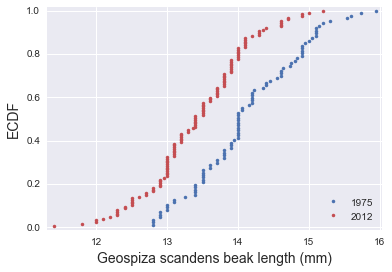

In [34]:
# Store data as Numpy arrays for speed later
s1975 = scandens1975['beak length (mm)'].values
s2012 = scandens2012['beak length (mm)'].values

# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(s1975)
x_pest, y_pest = bebi103.ecdf(s2012)

# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])
plt.margins(0.02)
plt.xlabel('Geospiza scandens beak length (mm)')
plt.ylabel('ECDF')
plt.legend(('1975', '2012'), loc='lower right');

This is the ECDF for Geospiza scandens beak length of 1975 and 2012.

In [35]:
print("The means of beak lengths from our data: \n" + str(sum(s1975) / len(s1975)) + " mm for 1975.")
print (str(sum(s2012) / len(s2012)) + " mm for 2012.")
print ("\nWe estimate mean lengths below.")

The means of beak lengths from our data: 
14.1209195402 mm for 1975.
13.421023622 mm for 2012.

We estimate mean lengths below.


In [36]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

In [37]:
def draw_bs_reps(data, stat_fun, size=10000):
    """
    Draw boostrap replicates computed with stat_fun from 1D data set.
    """
    return np.array([stat_fun(draw_bs_sample(data)) for _ in range(size)])


@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=10000):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out


@numba.jit(nopython=True)
def draw_bs_reps_median(data, size=10000):
    """
    Draw boostrap replicates of the median from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.median(draw_bs_sample(data))
    return out

@numba.jit(nopython=True)
def draw_bs_reps_std(data, size=10000):
    """
    Draw boostrap replicates of the standard deviation from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.std(draw_bs_sample(data))
    return out

In [38]:
bs_reps_mean_1975 = draw_bs_reps_mean(s1975)
bs_reps_mean_2012 = draw_bs_reps_mean(s2012)
meanEstimate1975 = sum(list(bs_reps_mean_1975)) / len(list(bs_reps_mean_1975))
meanEstimate2012 = sum(list(bs_reps_mean_2012)) / len(list(bs_reps_mean_2012))

In [39]:
print ("Average of the bootstrap replicates for the means of the two years.\n")

print("The mean estimate for beak length of Geospiza scandens in 1975 is " + str(meanEstimate1975) + " mm.")
print("The mean estimate for beak length of Geospiza scandens in 2012 is " + str(meanEstimate2012) + " mm.")

Average of the bootstrap replicates for the means of the two years.

The mean estimate for beak length of Geospiza scandens in 1975 is 14.1219046437 mm.
The mean estimate for beak length of Geospiza scandens in 2012 is 13.4217561811 mm.


In [40]:
# 95% confidence intervals
mean_1975 = np.percentile(bs_reps_mean_1975, [2.5, 97.5])
mean_2012 = np.percentile(bs_reps_mean_2012, [2.5, 97.5])

print("""
Mean 1975 Geospiza scandens beak length 95% conf int (mm):   [{0:.2f}, {1:.2f}]
Mean 2012 Geospiza scandens beak length 95% conf int (mm): [{2:.2f}, {3:.2f}]
""".format(*(tuple(mean_1975) + tuple(mean_2012))))


Mean 1975 Geospiza scandens beak length 95% conf int (mm):   [13.97, 14.28]
Mean 2012 Geospiza scandens beak length 95% conf int (mm): [13.30, 13.55]



<div class="alert alert-info">  The question was about beak depth, not length. Please read carefully next time and explain what you are doing. 8/10

# 7.2 C

In [ ]:
# Filter to get scandens
inds = df['species'] == 'scandens' 
allScandens = df.loc[inds, :]

# Get all scandens in 1975
inds1975 = allScandens['year'] == 1975
scandens1975 = allScandens.loc[inds1975, :]

# Get all scandens in 2012
inds2012 = allScandens['year'] == 2012
scandens2012 = allScandens.loc[inds2012, :]

# Get the beak depths into numpy arrays
depth1975 = np.array(scandens1975['beak depth (mm)'])
depth2012 = np.array(scandens2012['beak depth (mm)'])

**Null hypothesis**: The beak depths of *G. Scandens* in 1975 and 2012 have exactly the same distribution.

**Test statistic**: Difference of means of the distributions

**Simulation**: Follow the simulation described in Tutorial 7a, which is as follows

1) Concatenate the two data sets into one.

2) Randomly scramble the order of the combined data set.

3) Designate the first $n$ entries in this scrambled array to be "control" and the remaining to be "test."

We can take $n$ to be any positive integer less than the size of the combined data set. We will choose it to be the size of the data set of *G. Scandens* in 1975.

**Definition**: In this case, what it means to be at least as extreme as the test statistic is that the (absolute value of the) difference of means observed in a simulation trial is greater than the difference of means between the two unconcatenated data sets.

In [64]:
@numba.jit#(nopython=True)
def draw_perm_sample(x, y):
    '''Generate a permutation sample.'''
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]

@numba.jit#(nopython=True)
def draw_perm_reps_diff_mean(x, y, size=10000):
    '''
    Generate array of permuation replicates.
    '''
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = abs(np.mean(x_perm) - np.mean(y_perm))
    return out

# Compute test statistic for original data set
diff_mean = abs(np.mean(depth1975) - np.mean(depth2012))

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(depth1975, depth2012, size=100000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.01038


Our p-value is small (significant at 95% confidence level), perhaps not as small as we might like it to be, but small nontheless. This means that the probability of getting a difference of means under the null hypothesis as extreme as was observed from the actual data is quite small.

<div class="alert alert-info"> good 20/20

# 7.2 D

The scalar value for beak shape is (1/2) x beak length x beak depth. We can think of beak shape as being analagous to the area of a finch beak if laid on a two dimensional plane. The beak resembles that of a triangle with base of length beak depth and height of beak length and to get the area, we do 1/2 x base x height = 1/2 x beak length x beak depth.

In [43]:
lengths = list(df['beak length (mm)'])
widths = list(df['beak depth (mm)'])
shape = []
for i in range(len(lengths)):
    shape.append(0.5 * lengths[i] * widths[i])

In [44]:
df['Beak shape'] = shape

In [45]:
df.head()

,band,beak depth (mm),beak length (mm),species,year,Beak shape
0,20123.0,8.05,9.25,fortis,1973.0,37.23125
1,20126.0,10.45,11.35,fortis,1973.0,59.30375
2,20128.0,9.55,10.15,fortis,1973.0,48.46625
3,20129.0,8.75,9.95,fortis,1973.0,43.53125
4,20133.0,10.15,11.55,fortis,1973.0,58.61625


We now have an updated dataframe with a new column for our scalar "Beak shape" as shown above.

For the open-ended portion of this question, we are going to compare the two species in ~20 year intervals (1973, 1991, 2012) and see how the species compare against one another each of these years and how each species compares with itself over time.

In [46]:
# Filter to get fortis
inds = df['species'] == 'fortis' 
allFortis = df.loc[inds,: ]
allFortis.head()

,band,beak depth (mm),beak length (mm),species,year,Beak shape
0,20123.0,8.05,9.25,fortis,1973.0,37.23125
1,20126.0,10.45,11.35,fortis,1973.0,59.30375
2,20128.0,9.55,10.15,fortis,1973.0,48.46625
3,20129.0,8.75,9.95,fortis,1973.0,43.53125
4,20133.0,10.15,11.55,fortis,1973.0,58.61625


In [47]:
# Filter to get fortis
inds = df['species'] == 'scandens' 
allScandens = df.loc[inds,: ]
allScandens.head()

,band,beak depth (mm),beak length (mm),species,year,Beak shape
73,20121.0,9.35,15.15,scandens,1973.0,70.82625
74,20125.0,9.75,15.05,scandens,1973.0,73.36875
75,20135.0,8.35,14.45,scandens,1973.0,60.32875
76,20159.0,9.55,14.05,scandens,1973.0,67.08875
77,20160.0,8.55,14.25,scandens,1973.0,60.91875


In [48]:
# Filter to get data corresponding to years 1973, 1991, and 2012 of scanden species
inds1973 = allScandens['year'] == 1973
scandens1973 = allScandens.loc[inds1973, :]

inds1991 = allScandens['year'] == 1991
scandens1991 = allScandens.loc[inds1991, :]

inds2012 = allScandens['year'] == 2012
scandens2012 = allScandens.loc[inds2012, :]

In [49]:
# Filter to get data corresponding to years 1973, 1991, and 2012 of fortis species

inds1973 = allFortis['year'] == 1973
fortis1973 = allFortis.loc[inds1973, :]

inds1991 = allFortis['year'] == 1991
fortis1991 = allFortis.loc[inds1991, :]

inds2012 = allFortis['year'] == 2012
fortis2012 = allFortis.loc[inds2012, :]


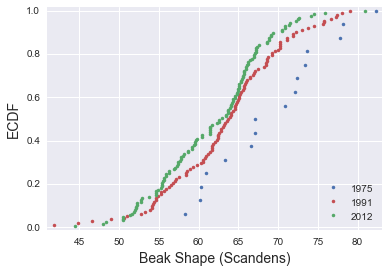

In [50]:
# Store data as Numpy arrays for speed later
s1973 = scandens1973['Beak shape'].values
s1991 = scandens1991['Beak shape'].values
s2012 = scandens2012['Beak shape'].values
# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(s1973)
x_pest, y_pest = bebi103.ecdf(s1991)
x_pest1, y_pest1 = bebi103.ecdf(s2012)

# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])
plt.plot(x_pest1, y_pest1, marker='.', linestyle='none', 
         color=sns.color_palette()[1])
plt.margins(0.02)
plt.xlabel('Beak Shape (Scandens)')
plt.ylabel('ECDF')
plt.legend(('1975', '1991', '2012'), loc='lower right');

Just visually looking at the ECDF, it appears that the beak shape has gotten smaller with time. Let's do another ECDF for the other species for the same years. 

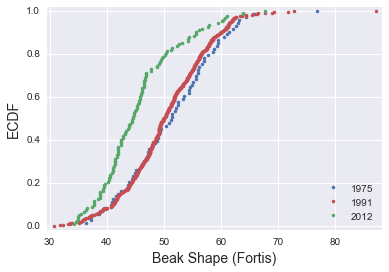

In [51]:
# Store data as Numpy arrays for speed later
f1973 = fortis1973['Beak shape'].values
f1991 = fortis1991['Beak shape'].values
f2012 = fortis2012['Beak shape'].values
# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(f1973)
x_pest, y_pest = bebi103.ecdf(f1991)
x_pest1, y_pest1 = bebi103.ecdf(f2012)

# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])
plt.plot(x_pest1, y_pest1, marker='.', linestyle='none', 
         color=sns.color_palette()[1])
plt.margins(0.02)
plt.xlabel('Beak Shape (Fortis)')
plt.ylabel('ECDF')
plt.legend(('1975', '1991', '2012'), loc='lower right');

We see a similar trend in the Fortis species, but a more drastic drop in beak shape from 1991 to 2012 and a smaller decrease in beak shape from 1975 to 1991. This may be attributed to the severe drought in 1976 and 1977 explored in part (c).

We will now keep the year constant, and plot ECDFs of the two species against one another for each year.

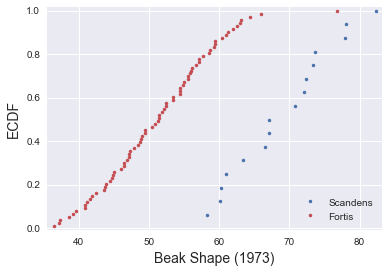

In [52]:
# Store data as Numpy arrays for speed later
s1973 = scandens1973['Beak shape'].values
f1973 = fortis1973['Beak shape'].values

# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(s1973)
x_pest, y_pest = bebi103.ecdf(f1973)


# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])

plt.margins(0.02)
plt.xlabel('Beak Shape (1973)')
plt.ylabel('ECDF')
plt.legend(('Scandens', 'Fortis'), loc='lower right');

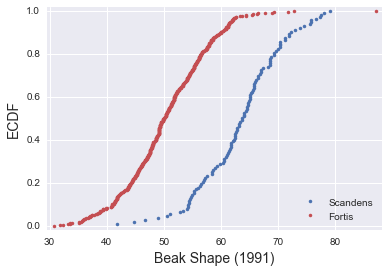

In [53]:
# Store data as Numpy arrays for speed later
s1991 = scandens1991['Beak shape'].values
f1991 = fortis1991['Beak shape'].values

# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(s1991)
x_pest, y_pest = bebi103.ecdf(f1991)


# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])

plt.margins(0.02)
plt.xlabel('Beak Shape (1991)')
plt.ylabel('ECDF')
plt.legend(('Scandens', 'Fortis'), loc='lower right');

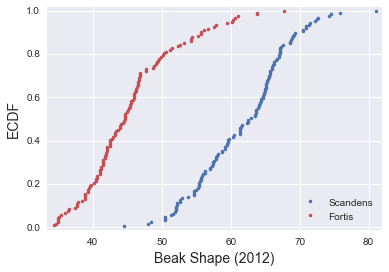

In [54]:
# Store data as Numpy arrays for speed later
s2012 = scandens2012['Beak shape'].values
f2012 = fortis2012['Beak shape'].values

# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(s2012)
x_pest, y_pest = bebi103.ecdf(f2012)


# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])

plt.margins(0.02)
plt.xlabel('Beak Shape (2012)')
plt.ylabel('ECDF')
plt.legend(('Scandens', 'Fortis'), loc='lower right');

Just looking at the ECDFs comparing the two species over time, it seems that finches of the specie Fortis have larger beak shapes than those of species Scandens. 

Now, to get some actual quantites, we will provide estimates for mean and confidence intervals for both species in each of the three years chosen (1973, 19991, and 2012).

In [55]:
# Mean estimates for scandens

bs_reps_mean_1973s = draw_bs_reps_mean(s1973)
bs_reps_mean_1991s = draw_bs_reps_mean(s1991)
bs_reps_mean_2012s = draw_bs_reps_mean(s2012)

meanEstimate1973s = sum(list(bs_reps_mean_1973s)) / len(list(bs_reps_mean_1973s))
meanEstimate1991s = sum(list(bs_reps_mean_1991s)) / len(list(bs_reps_mean_1991s))
meanEstimate2012s = sum(list(bs_reps_mean_2012s)) / len(list(bs_reps_mean_2012s))

# 95% confidence intervals for scandens
mean_1973s = np.percentile(bs_reps_mean_1973s, [2.5, 97.5])
mean_1991s = np.percentile(bs_reps_mean_1991s, [2.5, 97.5])
mean_2012s = np.percentile(bs_reps_mean_2012s, [2.5, 97.5])
# Mean estimates for fortis

bs_reps_mean_1973f = draw_bs_reps_mean(f1973)
bs_reps_mean_1991f = draw_bs_reps_mean(f1991)
bs_reps_mean_2012f = draw_bs_reps_mean(f2012)

meanEstimate1973f = sum(list(bs_reps_mean_1973f)) / len(list(bs_reps_mean_1973f))
meanEstimate1991f = sum(list(bs_reps_mean_1991f)) / len(list(bs_reps_mean_1991f))
meanEstimate2012f = sum(list(bs_reps_mean_2012f)) / len(list(bs_reps_mean_2012f))

# 95% confidence intervals for fortis
mean_1973f = np.percentile(bs_reps_mean_1973f, [2.5, 97.5])
mean_1991f = np.percentile(bs_reps_mean_1991f, [2.5, 97.5])
mean_2012f = np.percentile(bs_reps_mean_2012f, [2.5, 97.5])

print("""
1973 scandens beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}
1991 scandens beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}
2012 scandens beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}

""".format(meanEstimate1973s, mean_1973s[0], mean_1973s[1], meanEstimate1991s, mean_1991s[0], mean_1991s[1], meanEstimate2012s, mean_2012s[0], mean_2012s[1])) 
print("""
1973 fortis beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}
1991 fortis beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}
2012 fortis beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}

""".format(meanEstimate1973f, mean_1973f[0], mean_1973f[1], meanEstimate1991f, mean_1991f[0], mean_1991f[1], meanEstimate2012f, mean_2012f[0], mean_2012f[1])) 




1973 scandens beak shape mean: 69.01. The 95% conf int (mm^2): 65.68, 72.41
1991 scandens beak shape mean: 63.38. The 95% conf int (mm^2): 62.05, 64.73
2012 scandens beak shape mean: 61.76. The 95% conf int (mm^2): 60.58, 62.89



1973 fortis beak shape mean: 51.28. The 95% conf int (mm^2): 49.47, 53.10
1991 fortis beak shape mean: 50.34. The 95% conf int (mm^2): 49.69, 50.98
2012 fortis beak shape mean: 45.54. The 95% conf int (mm^2): 44.31, 46.77




With actual quantitative estimates, a lot of what we speculated in the plotting of our ECDFs appear to be supported. Among each species, we see decreasing beak shape means as time goes by and for each year, we see that scandens have a larger mean than fortis.

Let's now conduct some hypothesis tests and generate some p-values. 

First we will compare *Scandens* to *Fortis* for each year in {1973, 1991, 2012}, beginning in 1973. Our null hypothesis is that the distributions of beak shapes for the two species in 1973 are identical. Our test statistic is difference of means of the distributions. Our simulation will be the same as what we did for part c of this problem. In fact, we will use the same functions.

In [65]:
# Compute test statistic for original data set
diff_mean = abs(np.mean(s1973) - np.mean(f1973))

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(s1973, f1973, size=100000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0


Even with 100 thousand replicates, we still have a p-value of 0. Therefore the probability of observing a difference of means as extreme as the difference for the real data, under the null hypothesis, is extremely small. We can conclude that the assumption that the two distributions are identical is highly unlikely. There is strong evidence suggesting a difference between the means of the distributions.

Now we perform the same hypothesis test for the two species' distributions of 1991.

In [66]:
diff_mean = abs(np.mean(s1991) - np.mean(f1991))
perm_reps = draw_perm_reps_diff_mean(s1991, f1991, size=100000)
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0


Similarly to the distributions of 1973, the p-value is 0 even with 100 thousand replications. Similarly, in 1991, there is strong evidence against the null hypothesis that the two species beak shapes come from the same distribution. 

Now we perform the same hypothesis test for the two species' distributions of 2012.

In [69]:
diff_mean = abs(np.mean(s2012) - np.mean(f2012))
perm_reps = draw_perm_reps_diff_mean(s2012, f2012, size=10000)
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0


Again, our p-value is 0. Our assumption that the two distributions are equal seems incredibly unlikely.

Now we will compare two distributions of the same species but from different years. We will compare both species to itself for each subset of the years {1973, 1991, 2012}, which totals six hypothesis tests, 3 for each species.

We will begin with comparing *Scandens 1973* to *Scandens 1991*. The hypothesis test will be the same as those above, i.e. same null hypothesis, test statistic, and simulation.

In [76]:
diff_mean = abs(np.mean(s1973) - np.mean(s1991))
perm_reps = draw_perm_reps_diff_mean(s1973, s1991, size=10000)
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0045


Our p-value is 0.0045. As this is quite small, we can say that it is highly unlikely to observe a difference of means under this hypothesis that is as extreme as the difference observed in the actual data. It seems unlikely the two distributions are identical and suggests there is a change in beak shape from year 1973 to 1991 for Scandens.

Now we compare *Scandens 1973* to *Scandens 2012*.

In [77]:
diff_mean = abs(np.mean(s1973) - np.mean(s2012))
perm_reps = draw_perm_reps_diff_mean(s1973, s2012, size=10000)
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0


Our p-value is 0. It is therefore very unlikely to observe a difference of means under this hypothesis that is as extreme as the difference of means observed between the actual two distributions. Again, this suggests a change in Scandens beak shape from 1973 to 2012.

Now we compare *Scandens 1991* to *Scandens 2012*.

In [78]:
diff_mean = abs(np.mean(s1991) - np.mean(s2012))
perm_reps = draw_perm_reps_diff_mean(s1991, s2012, size=10000)
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.087


Our p-value is 0.087. This p-value indicates that it is somewhat unlikely, but not extremely unlikely, to observe a difference of means more extreme than the difference for the actual distributions under the hypothesis. We should not look to draw conclusions about the likelihood of the hypothesis and note that there is no significant difference (at the 95% confidence level) of a difference in Scandens beak shape from 1991 to 2012.

Now we will compare *Fortis* distributions, starting with *Fortis 1973* and *Fortis 1991*.

In [79]:
diff_mean = abs(np.mean(f1973) - np.mean(f1991))
perm_reps = draw_perm_reps_diff_mean(f1973, f1991, size=10000)
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.2984


Our p-value is 0.2984, which indicates that it is not particularly unlikely to observe a difference of means more extreme than the difference for the actual distributions under the hypothesis. There does not appear to be a significant difference in mean beak shape from 1973 to 1991 in Fortis beak shape.

Now we compare *Fortis 1973* and *Fortis 2012*.

In [80]:
diff_mean = abs(np.mean(f1973) - np.mean(f2012))
perm_reps = draw_perm_reps_diff_mean(f1973, f2012, size=10000)
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0


Our p-value is 0. This means that it is very unlikely to observe a difference of means under this hypothesis that is more extreme than the difference observed between means of the actual distributions. There is evidence suggesting a difference in beak shapes from 1973 to 2012.

Finally we compare *Fortis 1991* and *Fortis 2012*.

In [81]:
diff_mean = abs(np.mean(f1991) - np.mean(f2012))
perm_reps = draw_perm_reps_diff_mean(f1991, f2012, size=10000)
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0


Our p-value 0. Similarly, there is evidence suggesting that there is a difference from 1991 to 2012 in beak shapes for Fortis.

In summary, our speculations after looking at the ECDFs appear to be validated by the generated p-values.

<div class="alert alert-info"> 25/25

# 7.2 E

In [82]:
dfScandens = pd.read_csv('../data/scandens_beak_depth_heredity.csv', comment='#')
dfFortis = pd.read_csv('../data/fortis_beak_depth_heredity.csv', comment='#')

In [83]:
mid_parentS = np.asarray(dfScandens['mid_parent'].values)
mid_offS = np.asarray(dfScandens['mid_offspring'].values)
dfScandens.head()

,mid_parent,mid_offspring
0,8.3318,8.4190
1,8.4035,9.2468
2,8.5317,8.1532
3,8.7202,8.0089
4,8.7089,8.2215


In [84]:
mid_parentF = []
maleBD = dfFortis['Male BD']
femaleBD = dfFortis['Female BD']
for i in range(len(maleBD)):
    mid_parentF.append((maleBD[i] + femaleBD[i]) / 2)
dfFortis['mid_parent'] = mid_parentF
mid_parentF = np.asarray(mid_parentF)
mid_offF = np.asarray(dfFortis['Mid-offspr'].values)

In [85]:
dfFortis.head()

,Mid-offspr,Male BD,Female BD,mid_parent
0,10.70,10.90,9.3,10.100
1,9.78,10.70,8.4,9.550
2,9.48,10.70,8.1,9.400
3,9.60,10.70,9.8,10.250
4,10.27,9.85,10.4,10.125


Note we have an extra column (called 'mid_parent') now, that stores the average of parent beak depth: $\frac{\text{Male BD + Female BD}}{2}$.

In [86]:
def calculateRatio(parents, offspring):
    variance = np.var(parents)
    covariance = np.cov(parents, offspring)
    cov = covariance[0,1]
    return cov/variance

In [87]:
def returnBootStrapPairs(x, y):
    n = len(x)
    inds = np.arange(n)
    bs_inds = np.random.choice(inds, size=n)
    bs_x, bs_y = x[bs_inds], y[bs_inds]
    return bs_x, bs_y

In [88]:
# We will now determine mean and confidence intervals for the Scandens species
ratioS = []

for i in range(10000): # 10000 bootstrap runs
    parent, off = returnBootStrapPairs(mid_parentS, mid_offS) # This function swaps indices to keep parent/offspring pairing
    ratioS.append(calculateRatio(parent, off))
totalSum = 0
for j in ratioS:
    totalSum += np.mean(j)
meanEstimateS = totalSum/ len(ratioS)  #Calculate mean estimate
confidenceIntervalS = np.percentile(ratioS, [2.5, 97.5])  #Calculate CI

In [89]:
# We will now determine mean and confidence intervals for the Fortis species
ratioF = []

for i in range(100000):
    parent, off = returnBootStrapPairs(mid_parentF, mid_offF)
    ratioF.append(calculateRatio(parent, off))
totalSum = 0
for j in ratioF:
    totalSum += np.mean(j)
meanEstimateF = totalSum/ len(ratioF)
confidenceIntervalF = np.percentile(ratioF, [2.5, 97.5])

In [90]:
print("""
Scandens heritability ratio mean: {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]
Fortis heritability ratio mean: {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimateS, confidenceIntervalS[0], confidenceIntervalS[1], meanEstimateF, confidenceIntervalF[0], confidenceIntervalF[1]))


Scandens heritability ratio mean: 0.555. The 95% conf int : [0.354, 0.760]
Fortis heritability ratio mean: 0.725. The 95% conf int : [0.648, 0.799]




<div class="alert alert-info"> It is hard to understand what you are doing just from reading your code, please explain in markdown!

It seems that you computed heritability from bootstrap replicates; these are useful to compute confidence intervals and null hypothesis tests, but should not replace the data for computing basic statistics. The value is unlikely to change much, but it is not what you intended to report.

Introgressive hybridization seems likely. It appears that the Fortis species has a higher heritability ratio than that of the Scanden species. We should take note that the Scandens species has a much larger confidence interval than that of the Fortis species, and furthermore, the fortis heritability ratio mean lies in the scandens 95% confidence interval. Thus, although the Fortis species has a higher heritability ratio, this difference is not signicant at the 95% confidence level.

From the given definition of heritability, this would suggest that, although not significant, the Fortis species is more apt at repeated backcrossing and transferring the specific trait of beak depth to the other Scandens species. Perhaps, over many generations, the Scandens may start having beak depths resembling that of Fortis. 

<div class="alert alert-info"> 20/25